<a href="https://colab.research.google.com/github/god05212/NLP/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용한 데이터셋
> Fake and real news dataset: Classifying the news

- Clément Bisaillon
- https://www.kaggle.com/clmentbisaillon
- https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Basic Exploration

## Read dataset

In [1]:
from google.colab import files
updloaded = files.upload()

Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [24]:
import pandas as pd
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

> target 변수를 설정하고 진짜 및 가짜 뉴스 데이터 세트를 모두 결합합니다.

## Some information

> 데이터 내용 표시

In [25]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,McPain: John McCain Furious That Iran Treated ...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,How to Blow $700 Million: Al Jazeera America F...


> 데이터의 null 값을 확인합니다.

In [26]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data preprocessing

> 텍스트 데이터에는 도움이 되지 않을 수 있는 구성요소가 존재합니다. 이 섹션의 주요 목표는 보다 원활한 분석을 위해 이러한 구성 요소를 제거하는 것입니다. 제공된 데이터에서 불용어(Stopwords)를 제거하는 기능을 만들 계획입니다. 분석 및 예측 중에 필요한 경우 이 기능을 사용할 것입니다.

In [27]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# 텍스트 전처리 함수
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)            
    return result
# 일치하지 않는 제목을 동일한 표기법으로 변환합니다
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

> 진짜 뉴스와 가짜 뉴스 분포 확인

In [28]:
import plotly.express as px
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

> 데이터 셋이 균형 잡힌 것처럼 보이기 때문에 균형 있게 만들기 위해 노력할 필요가 없습니다.

> 어떤 주제가 많나 확인해보겠습니다.

In [29]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

> PoliticalNews와 WorldNews가 데이터 셋에서 가장 많은 지배적인 카운트를 보유하고 있습니다.

> 뉴스 헤드라인이 뉴스가 가짜인지 아닌지를 예측하기에 충분할까? 다음 분석에서 확인할 수 있습니다.

In [30]:
import gensim
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [31]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

> 제목에 대한 Word Cloud를 살펴보도록 하겠습니다.
진짜 뉴스 헤드라인을 사용하여 Word Cloud를 확인합니다.

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
# plt.imshow(wc, interpolation = 'bilinear')

<Figure size 1440x1440 with 0 Axes>

> 가짜 뉴스 헤드라인을 사용하여 Word Cloud를 확인합니다.

In [33]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
# plt.imshow(wc, interpolation = 'bilinear')

<Figure size 1440x1440 with 0 Axes>

> 제목에 있는 단어 수 분포를 살펴보겠습니다.

In [34]:
nltk.download('punkt')
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The maximum number of words in a title is = 34


> 평균적으로 최대 제목 수는 7-8단어 사이입니다. 이 몇 마디 말만으로 뉴스가 사실인지 가짜인지 판단하기가 좀 어려울 것 같습니다. 그래서 우리는 제목만으로 많은 정확성을 얻지 못할 것 같습니다. 그럼 이제 예측으로 넘어가겠습니다.

# Machine Learning model

## Logistic Regression

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.947466974653341


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



> 94.75%의 정확도로, 예상과 다르게 꽤 좋은 결과입니다. 이제 제목만 사용하여 이 모델에 대한 Confusion Matrix를 살펴보겠습니다.

<AxesSubplot:>

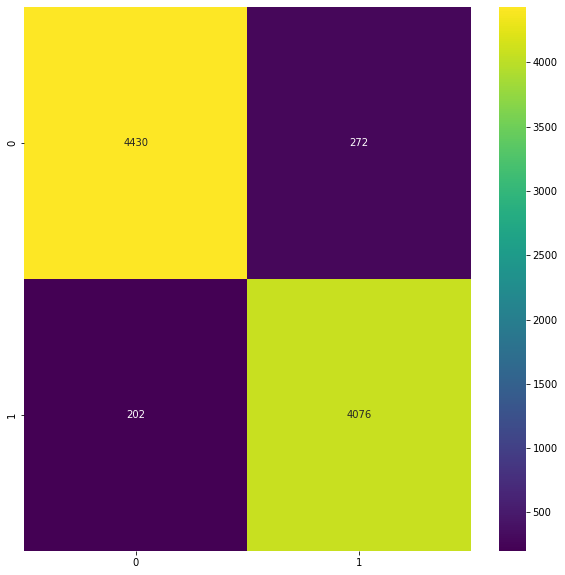

In [37]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

> 4430개의 가짜 뉴스는 가짜로 분류되었고, 4076개의 진짜 뉴스는 진짜로 분류되었습니다. 하지만 여전히 474개는 잘못 분류되고 있다는 것을 알 수 있습니다.

> 진짜 뉴스를 사용하여 Word Cloud를 만들 것입니다.

In [38]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
# plt.imshow(wc, interpolation = 'bilinear')

<Figure size 1440x1440 with 0 Axes>

> 이제 가짜 뉴스를 사용하여 Word Cloud를 만들 것입니다.

In [39]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
# plt.imshow(wc, interpolation = 'bilinear')

<Figure size 1440x1440 with 0 Axes>

> 텍스트에서 단어 수의 분포를 확인해 보겠습니다.

In [ ]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

> 우리가 볼 수 있듯이 대부분의 뉴스 기사는 100-200단어 범위 내에 있습니다. 단어의 수가 많으면 모델이 예측하기가 훨씬 쉬워집니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

> 99.53%로 상당히 좋아졌습니다. 제목에서 예측하는 것보다 훨씬 낫습니다. 정확도가 매우 높기 때문에 Confusion Matrix를 한 번 살펴보도록 하겠습니다.

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

> 가짜 뉴스 4687건이 가짜로 분류됐고, 진짜 뉴스 4252건도 제대로 예측됐습니다. 그리고 현재 41개는 잘못 분류되고 있습니다. 첫 번째 모델에서 크게 개선되었지만 제목과 내용을 합치면 더 좋은 결과를 얻을 수 있을 것 같습니다. 다음 섹션에서 확인해 보겠습니다.

> 제목과 내용을 고려하면 얼마나 정확하게 예측할 수 있는지 분석해 보겠습니다.

In [ ]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

> 바로 예측으로 건너뜁니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

> 99.67%로 우리는 뉴스의 제목과 내용을 모두 고려하여 뉴스의 본질을 예측할 수 있었습니다. confusion matrix를 살펴보도록 하겠습니다.

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

# Conclusion

> 뉴스 분류 목표에 성공적으로 도달했으며, 뉴스가 진짜인지 가짜인지 식별할 수 있습니다. 제목만으로 뉴스를 예측하는 것은 비교적 정확도가 낮았습니다. 뉴스기사 맥락을 고려했을 때 정확도 비율은 94%에서 99%로 급증했습니다.
제목과 맥락을 모두 고려할 때, 우리는 가장 높은 정확도에 도달할 수 있었습니다. 저는 더 나은 결과를 제공할 수 있는 추가 모델을 구현하기 위해 노력할 것입니다.

> 